<a href="https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/verification/image_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Regression

Here we map CASA 6 image tasks to the equivalent CNGI functionality and show that the resulting numerical output is the same


In [1]:
import os, warnings
warnings.simplefilter("ignore", category=RuntimeWarning)  # suppress warnings about nan-slices
print("installing cngi (takes a few minutes)...")
os.system("apt-get install libgfortran3")
os.system("pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatasks==6.0.0.27")
os.system("pip install cngi-prototype==0.0.49")

print("downloading MeasurementSet from CASAguide First Look at Imaging...")
os.system("wget https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar")
os.system("tar -xvf sis14_twhya_calibrated_flagged.ms.tar")

from casatasks import tclean
from cngi.conversion import convert_image
from cngi.image import implot
import numpy as np
print("running tclean to generate an image")
tclean(vis='sis14_twhya_calibrated_flagged.ms', imagename='sis14_twhya_calibrated_flagged', field='5', spw='',
       specmode='cube', deconvolver='hogbom', nterms=1, imsize=[250,250], gridder='standard', cell=['0.1arcsec'],
       nchan=10, weighting='natural', threshold='0mJy', niter=5000, interactive=False, savemodel='modelcolumn',
       usemask='auto-multithresh')

image_xds = convert_image('sis14_twhya_calibrated_flagged.image', artifacts=['image'])

installing cngi (takes a few minutes)...
downloading MeasurementSet from CASAguide First Look at Imaging...
running tclean to generate an image
converting Image...
compatible components:  ['image']
separate components:  []
processed image size [250 250   1  10] in 0.5919421 seconds



---

## imsubimage

copy all or part of an image to a new image

converting Image...
compatible components:  ['image']
separate components:  []
processed image size [50 50  1 10] in 0.33085394 seconds


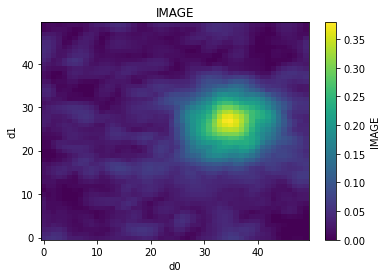

In [2]:
# CASA6
from casatasks import imsubimage

imsubimage('sis14_twhya_calibrated_flagged.image', outfile='casa6.subimage.image', box='85,100,134,149', overwrite=True)

casa_xds = convert_image('casa6.subimage.image')
implot(casa_xds.IMAGE)

In [0]:
# CNGI
cngi_xds = image_xds.isel(d0=range(85,135), d1=range(100,150))

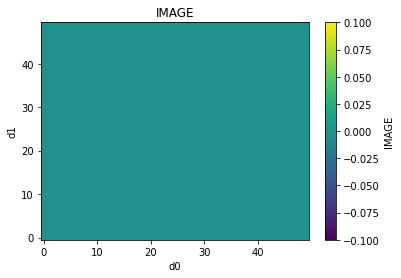

max delta :  0.0


In [4]:
# Delta
implot(casa_xds.IMAGE - cngi_xds.IMAGE)
print('max delta : ', np.abs((casa_xds.IMAGE - cngi_xds.IMAGE).values).max())


---

## imtrans

reorders (transposes) the axes in the input image to the specified order


converting Image...
compatible components:  ['image']
separate components:  []
processed image size [250 250   1  10] in 0.5500314 seconds


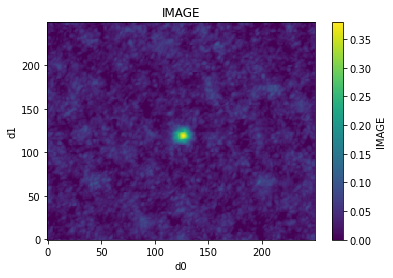

In [5]:
# CASA6
from casatasks import imtrans

os.system("rm -fr casa6.trans.image")
imtrans('sis14_twhya_calibrated_flagged.image', outfile='casa6.trans.image', order='1023')

casa_xds = convert_image('casa6.trans.image')
implot(casa_xds.IMAGE)

In [0]:
# CNGI
cngi_xds = image_xds.transpose('d1','d0','chan','pol')

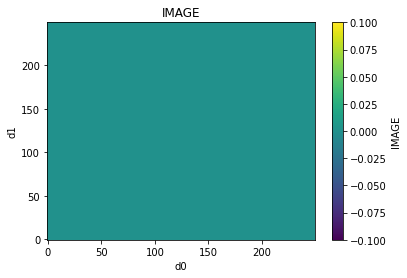

max delta :  0.0


In [7]:
# Delta
implot(casa_xds.IMAGE - cngi_xds.IMAGE.values)
print('max delta : ', np.abs(casa_xds.IMAGE.values - cngi_xds.IMAGE.values).max())


---

## imcollapse

collapse an image along a specified axis or set of axes of N pixels into a single pixel on each specified axis.

converting Image...
compatible components:  ['image']
separate components:  []
processed image size [250 250   1   1] in 0.0929544 seconds


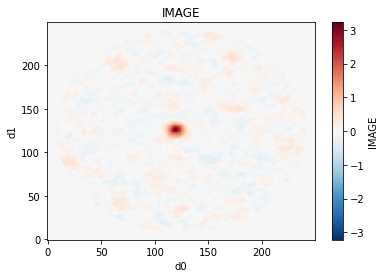

In [8]:
# CASA6
from casatasks import imcollapse

imcollapse('sis14_twhya_calibrated_flagged.image', function='sum', axes=[2,3], outfile='casa6.collapse.image', overwrite=True)

casa_xds = convert_image('casa6.collapse.image')
implot(casa_xds.IMAGE)

In [0]:
# CNGI
cngi_xds = image_xds.where(image_xds.MASK).sum(dim=['chan','pol'])

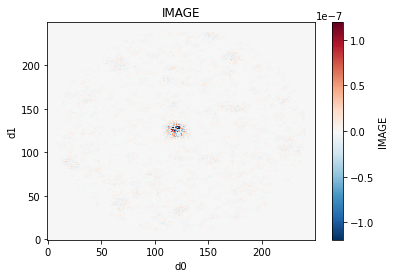

max delta :  1.1920928955078125e-07


In [10]:
# Delta
implot(casa_xds.IMAGE - cngi_xds.IMAGE)
print('max delta : ', np.abs((casa_xds.IMAGE - cngi_xds.IMAGE).values).max())


---

## makemask


converting Image...
compatible components:  ['image']
separate components:  []
processed image size [250 250   1  10] in 0.37148356 seconds


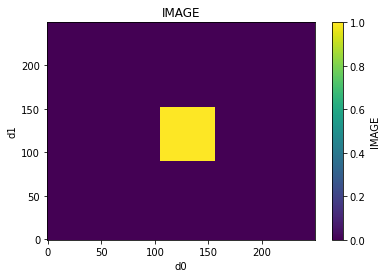

In [11]:
# CASA6
from casatasks import makemask

makemask(mode='copy', inpimage='sis14_twhya_calibrated_flagged.image', inpmask='box[[2.887905rad, -0.60573rad], [2.887935rad, -0.60570rad]]', 
         output='casa6.makemask.image', overwrite=True)

casa_xds = convert_image('casa6.makemask.image')
implot(casa_xds.IMAGE)

In [0]:
# CNGI
from cngi.image import region

# note that CASA swaps the meaning of 0/1 between regions and masks, CNGI does not
# so replicating the values of a CASA mask requires us to use a CNGI region
cngi_xds = region(image_xds, 'MASK1', ra=[2.887905, 2.887935], dec=[-0.60573, -0.60570])

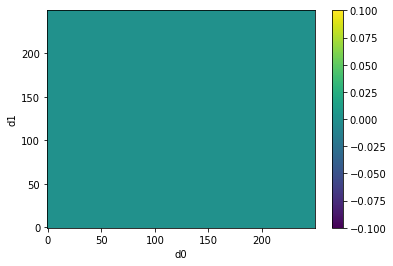

max delta :  0.0


In [13]:
# Delta
implot(casa_xds.IMAGE - cngi_xds.MASK1)
print('max delta : ', np.abs((casa_xds.IMAGE - cngi_xds.MASK1).values).max())


---

## imval

Note the mechanism for retrieving data from the image is fundamentally different, but the data itself is the same

In [14]:
# casa6
from casatasks import imval

imval('sis14_twhya_calibrated_flagged.image', box='85,100,86,102', chans='2')

{'axes': [[0, 'Right Ascension'],
  [1, 'Declination'],
  [3, 'Frequency'],
  [2, 'Stokes']],
 'blc': [85, 100, 0, 2],
 'coords': array([[[ 2.88794689e+00, -6.05725563e-01,  1.00000000e+00,
           3.72521243e+11],
         [ 2.88794689e+00, -6.05725079e-01,  1.00000000e+00,
           3.72521243e+11],
         [ 2.88794689e+00, -6.05724594e-01,  1.00000000e+00,
           3.72521243e+11]],
 
        [[ 2.88794630e+00, -6.05725563e-01,  1.00000000e+00,
           3.72521243e+11],
         [ 2.88794630e+00, -6.05725079e-01,  1.00000000e+00,
           3.72521243e+11],
         [ 2.88794630e+00, -6.05724594e-01,  1.00000000e+00,
           3.72521243e+11]]]),
 'data': array([[0.01390967, 0.01842283, 0.01985601],
        [0.00298489, 0.00613136, 0.00940997]]),
 'mask': array([[ True,  True,  True],
        [ True,  True,  True]]),
 'trc': [86, 102, 0, 2],
 'unit': 'Jy/beam'}

In [15]:
# cngi
image_xds.isel(d0=range(85,87), d1=range(100,103)).compute()

<xarray.Dataset>
Dimensions:          (chan: 10, d0: 2, d1: 3, pol: 1)
Coordinates:
  * chan             (chan) float64 3.725e+11 3.725e+11 ... 3.725e+11 3.725e+11
    declination      (d0, d1) float64 -0.6057 -0.6057 ... -0.6057 -0.6057
  * pol              (pol) float64 1.0
    right_ascension  (d0, d1) float64 2.888 2.888 2.888 2.888 2.888 2.888
Dimensions without coordinates: d0, d1
Data variables:
    IMAGE            (d0, d1, chan, pol) float64 0.0 0.04391 ... 0.03164 0.01311
    MASK             (d0, d1, chan, pol) bool True True True ... True True True
Attributes:
    axisunits:            ['rad', 'rad', '', 'Hz']
    commonbeam:           [0.6530517935752869, 0.5046663284301758, -66.009117...
    commonbeam_units:     ['arcsec', 'arcsec', 'deg']
    date_observation:     2012/11/19/07
    direction_reference:  j2000
    imagetype:            Intensity
    incr:                 [-4.84813681109536e-07, 4.84813681109536e-07, 1.0, ...
    object_name:          tw hya
    observer:             cqi
    pointing_center:      11
    rest_frequency:       3.7265e+11 hz
    restoringbeam:        [[[0.6530517935752869, 0.5046663284301758, -66.0091...
    spectral__reference:  lsrk
    telescope:            alma
    telescope_position:   [2.22514e+06m, -5.44031e+06m, -2.48103e+06m] (itrf)
    unit:                 Jy/beam
    velocity__type:       radio


---

## imrebin

Note that CASA bins pixels starting from the edge of the mask/region. CNGI bins pixels starting from the edge of the image (ignoring values in masked pixels). This creates a discrepency in output at the edge of masks.

converting Image...
compatible components:  ['image']
separate components:  []
processed image size [ 83 250   1  10] in 0.44775915 seconds


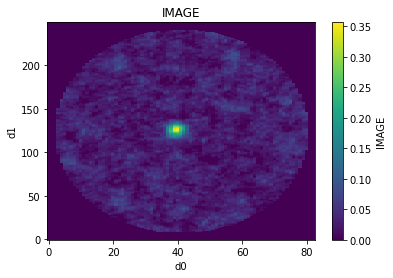

In [16]:
# CASA6
from casatasks import imrebin

imrebin(imagename='sis14_twhya_calibrated_flagged.image', outfile='casa6.rebin.image', factor=3, overwrite=True)

casa_xds = convert_image('casa6.rebin.image')
implot(casa_xds.IMAGE)

In [0]:
# CNGI
from cngi.image import rebin

cngi_xds = rebin(image_xds.where(image_xds.MASK), axis='d0', factor=3)

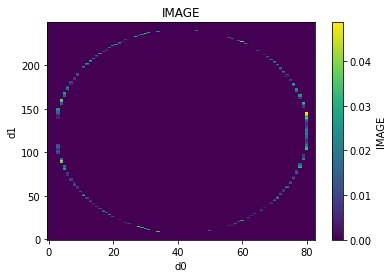

max delta :  0.04867842296759288


In [18]:
# Delta
implot(casa_xds.IMAGE - cngi_xds.IMAGE)
print('max delta : ', np.abs((casa_xds.IMAGE - cngi_xds.IMAGE).values).max())


---

## imsmooth

Note there is currently a discrepency in output that is not understood


converting Image...
compatible components:  ['image']
separate components:  []
processed image size [250 250   1  10] in 0.40842056 seconds


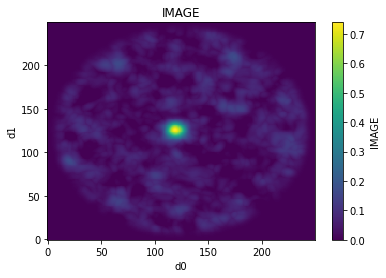

In [19]:
# CASA6
from casatasks import imsmooth

imsmooth('sis14_twhya_calibrated_flagged.image', kernel='gaussian', targetres=True, outfile='casa6.smooth.image', 
         overwrite=True, beam = {"major": "1arcsec", "minor": "1arcsec", "pa": "30deg"});

casa_xds = convert_image('casa6.smooth.image')
implot(casa_xds.IMAGE)

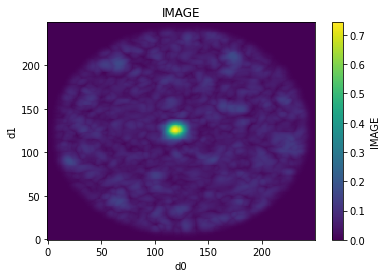

In [20]:
# CNGI
from cngi.image import smooth, gaussianbeam

cngi_xds = smooth(image_xds.where(image_xds.MASK, other=0), kernel='gaussian', size=[1., 1., 30.], 
                  current=image_xds.commonbeam, name='TARGET_BEAM')
implot(cngi_xds.IMAGE)

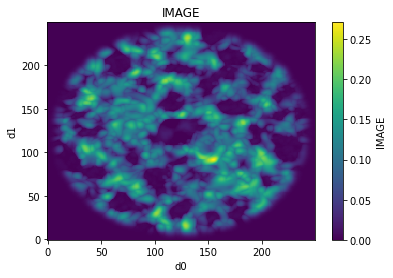

max delta :  0.27090430626856465


In [21]:
# Delta
implot((cngi_xds.IMAGE - casa_xds.IMAGE)[:,:,:,:])
print('max delta : ', np.abs((casa_xds.IMAGE - cngi_xds.IMAGE).values).max())


---

## Execute this Notebook in Colab

https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/verification/image_regression.ipynb